## **Import**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy import percentile
from math import cos, sin, pi, sqrt, atan
import matplotlib.pyplot as plt
import fingerprint_feature_extractor
import fingerprint_enhancer

## **Load Data**

In [ ]:
#dir = 'D:\\Nhan Dang\\FVC2004\\'
dir = 'E:\\Cross_Fingerprint_Images_Database\\contact-based_fingerprints\\'
os.chdir(dir+'first_session\\')
#os.chdir(dir+'FVC2004_DB4_B\\')
filenames = os.listdir()
filenames[:5]

['100_1.jpg', '100_2.jpg', '100_3.jpg', '100_4.jpg', '100_5.jpg']

In [ ]:
def imshow(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

(356, 328)


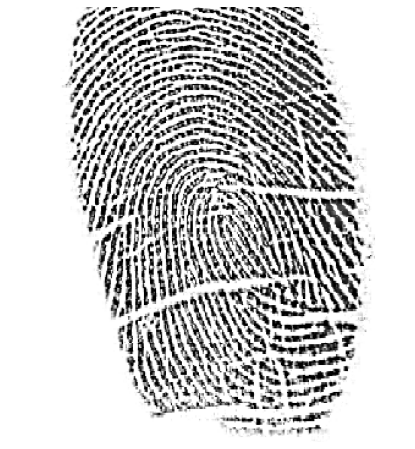

In [ ]:
img = cv2.imread(filenames[16], cv2.IMREAD_GRAYSCALE)
print(img.shape)
imshow(img)

## **Image Enhancement using Gabor Filter**

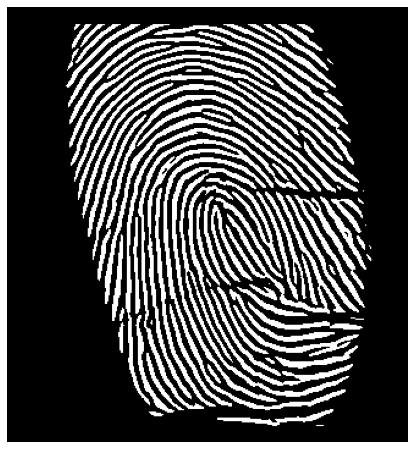

In [ ]:
img_enhanced = fingerprint_enhancer.enhance_Fingerprint(img)
imshow(img_enhanced)

## **Features Extraction**

Skeletonizing:





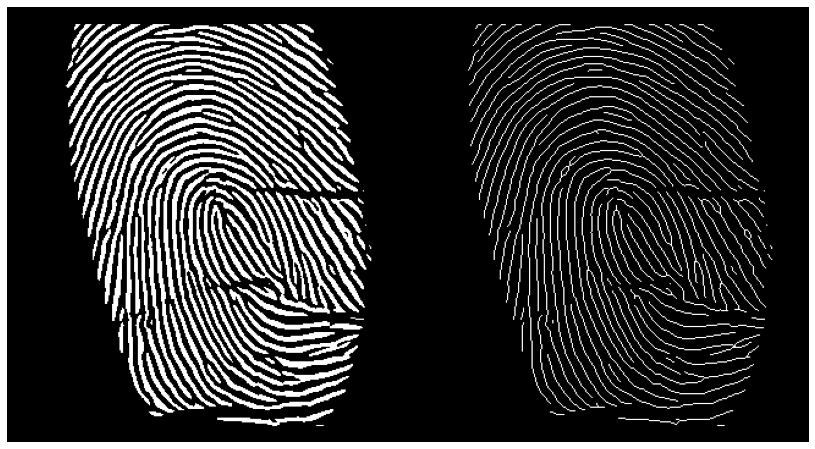

In [ ]:
import skimage.morphology
img_tmp = np.uint8(img_enhanced > 128)
img_skeletionized = skimage.morphology.skeletonize(img_tmp)
img_skeletionized = np.uint8(img_skeletionized) * 255
imshow(np.concatenate((img_enhanced,img_skeletionized), axis=1))

Features Extracting:

In [ ]:
Terminations, Bifurcations = fingerprint_feature_extractor.extract_minutiae_features(img_enhanced, showResult=False, spuriousMinutiaeThresh=10)
for bif in Bifurcations:
  bif.Orientation = [sum(bif.Orientation)/3]

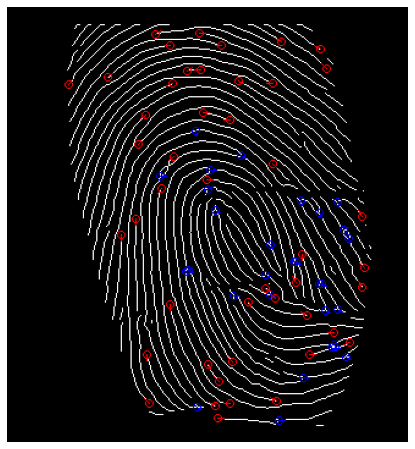

In [ ]:
to_rad = pi/180.0

def draw_orientation(locX, locY, Orientation, DispImg, Otype: bool): 
  '''
  Draws line(s) indicate(s) the orientation of the minutia

  Parameters
  ----------
  locX, locY : int
      The location of the minutia
  Orientation : float (degree)
      The orientation of the current minutia
  DispImg : ndarray
      Array of the fingerprint image
  Otype : bool
      Type of the minutia. 
      0: Bifurcation
      1: Termination

  Returns
  -------
  out : ndarray
      Array of the fingerprint image
  '''
  X_orientation = locX - 5 * sin(Orientation * to_rad)
  Y_orientation = locY + 5 * cos(Orientation * to_rad)

  (rr, cc) = skimage.draw.line(locX, locY, int(X_orientation), int(Y_orientation))
  skimage.draw.set_color(DispImg, (rr, cc), (255*(1-Otype), 0, 255*Otype))
  return DispImg

(rows, cols) = img_skeletionized.shape
DispImg = np.zeros((rows, cols, 3), np.uint8)
DispImg[:, :, 0] = img_skeletionized
DispImg[:, :, 1] = img_skeletionized
DispImg[:, :, 2] = img_skeletionized

for Bif in Bifurcations:
  (rr, cc) = skimage.draw.circle_perimeter(Bif.locX, Bif.locY, 3)
  skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0))
  draw_orientation(Bif.locX, Bif.locY, Bif.Orientation[0], DispImg, 0)
  #for Orientation in Bi.Orientation:
    #draw_orientation(Bi.locX, Bi.locY, Orientation, DispImg, 0)

for Term in Terminations:
  (rr, cc) = skimage.draw.circle_perimeter(Term.locX, Term.locY, 3)
  skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255))
  draw_orientation(Term.locX, Term.locY, Term.Orientation[0], DispImg, 1)

imshow(DispImg)

In [ ]:
def d_phi(t1, t2):
    if (t1-t2) <= -pi:
        return 2*pi+t1-t2
    elif (t1-t2) > pi:
        return 2*pi-t1+t2
    else:
        return t1-t2

def dist(m1, m2):
    return sqrt((m1.locX-m2.locX)**2+(m1.locY-m2.locY)**2)

def theta(m1, m2):
    if m1.locX-m2.locX == 0:
        if m1.locY-m2.locY > 0:
            return d_phi(atan(pi/2), m1.Orientation)
        elif m1.locY-m2.locY < 0:
            return d_phi(atan(-pi/2), m1.Orientation)
        else:
            return d_phi(0, m1.Orientation)
    else:
        return d_phi(atan((m1.locY-m2.locY)/(m1.locX-m2.locX)), m1.Orientation)

def minus(Fi, Fj, n=3):
    F = np.empty(4*n+1)
    for i in range(n):
        F[i] = Fi[i] - Fj[i]
        F[i+n] = d_phi(Fi[i+n], Fj[i+n])
        F[i+2*n] = d_phi(Fi[i+2*n], Fj[i+2*n])
        F[i+3*n] = Fi[i+3*n] - Fj[i+3*n]
    F[4*n] = Fi[4*n] - Fj[4*n]
    return F

def n_neighbors(Minutiae, Minutia, n):
    dist_list=[]
    for i in Minutiae:
        if [Minutia.locX, Minutia.locY] != [i.locX, i.locY]:
            dist_list.append([dist(Minutia, i), i])
    dist_list.sort(key=lambda x: x[0])

    result = []
    for i in range(n):
        result.append(dist_list[i][1])
    return result

In [ ]:
def feature_extractor(fingerprint_image, n):
    img_enhanced = fingerprint_enhancer.enhance_Fingerprint(fingerprint_image)
    Terminations, Bifurcations = fingerprint_feature_extractor.extract_minutiae_features(img_enhanced, showResult=False, spuriousMinutiaeThresh=10)
  
    for bif in Bifurcations:
        bif.Orientation = sum(bif.Orientation)/3*to_rad
    for term in Terminations:
        term.Orientation = term.Orientation[0]*to_rad
    
    Minutiae = Terminations + Bifurcations
    features = []

    for Minutia in Minutiae:
        neighbors = n_neighbors(Minutiae, Minutia, n)
        dists = []
        thetas = []
        phis = []
        otypes = [int(Minutia.Type == 'Termination')]
        for i in range(n):
          dists.append(dist(Minutia, neighbors[i]))
          thetas.append(theta(Minutia, neighbors[i]))
          phis.append(d_phi(Minutia.Orientation, neighbors[i].Orientation))
          otypes.append(int(neighbors[i].Type == 'Termination'))
            
        features.append([Minutia, np.array(dists+thetas+phis+otypes)])
        
    features = np.array(features, dtype=object)
    return features

### Save extracted features to files:

In [ ]:
from numpy import save

for i, name in enumerate(filenames):
    img = cv2.imread(name)
    data = feature_extractor(img, 3)
    save(dir+'DB4_B_processed\\'+name[:-4]+'.npy', data)
    if i%10 == 0:
        print(i,'/ 80')

0 / 80
10 / 80
20 / 80
30 / 80
40 / 80
50 / 80
60 / 80
70 / 80


In [ ]:
# from numpy import save

# for i, name in enumerate(filenames):
#     if name[-3:] == 'tif':
#         img = cv2.imread(name)
#         data = feature_extractor(img, 3)
#         save(dir+'FVC2004_DB4_B_processed\\'+name[:-4]+'.npy', data)
#         if i%10 == 0:
#             print(i,'/ 80')

## Local structure matching

In [ ]:
#similarity level (local structure matching)
def similarity(Fi, Fj, n=3):
    bl = 7 * (n * 4 + 1)
    W_ds = []
    W_thetas = []
    W_phis = []
    W_ts = [0]
    for i in range(n):
        W_ds.append(1)
        W_thetas.append(0.3)
        W_phis.append(0.3)
        W_ts.append(1)
    W = np.array(W_ds+W_thetas+W_phis+W_ts)
    
    differences = W.dot(abs(minus(Fi, Fj, n)))
    if differences < bl:
        return ((bl - differences) / bl)
    else: 
        return 0 

In [ ]:
dir = 'D:\\Nhan Dang\\FVC2004\\DB4_B_processed\\'
#dir = 'D:\\Nhan Dang\\FVC2004\\FVC2004_DB4_B_processed\\'
filenames = os.listdir(dir)

## Global structure matching

### Best matched:

In [ ]:
def matches(fing1, fing2, n=3): # calculating similarity levels between pairs of local structures
    sls = [] 
    for i, Fi in enumerate(fing1):
        for j, Fj in enumerate(fing2):
            sl_ij = similarity(Fi[1], Fj[1], n)
            if sl_ij > 0: 
                sls.append([[i,j], sl_ij])

    sls.sort(reverse=True, key=lambda x: x[1])

    return sls #sls: [[position_Template, position_Input], similarity_level]

In [ ]:
def compare_bounding_box(Fgi, Fgj): #Compare the minutia deformation with the bounding box
    Bg = np.array([8, pi/4, pi/4])
    deformation = abs(np.array([Fgi[0] - Fgj[0], d_phi(Fgi[1], Fgj[1]), d_phi(Fgi[2], Fgj[2])]))
    
    return (deformation < Bg).all()

In [ ]:
def matching_levels(fing1, fing2, similarity_levels): #calculate matching certainty levels based on best-matched structure pair
    
    b1 = fing1[similarity_levels[0][0][0]][0]
    Fgi = []
    for minutia in fing1:
        Fgi.append([dist(b1, minutia[0]), theta(minutia[0], b1), d_phi(minutia[0].Orientation, b1.Orientation)])
    
    b2 = fing2[similarity_levels[0][0][1]][0]
    Fgj = []
    for minutia in fing2:
        Fgj.append([dist(b2, minutia[0]), theta(minutia[0], b2), d_phi(minutia[0].Orientation, b2.Orientation)])
     
    mls = []
    for sl in similarity_levels:
        if compare_bounding_box(Fgi[sl[0][0]], Fgj[sl[0][1]]):
            mls.append([sl[0], 0.5+0.5*sl[1]])
    
    return mls

In [ ]:
def matching_score(fing1, fing2, n):
    similarity_levels = matches(fing1, fing2, n)
    
    mls = matching_levels(fing1, fing2, similarity_levels)
    
    ml_sum = 0
    matched = [[],[]]
    
    for i in mls:
        if (i[0][0] not in matched[0]) & (i[0][1] not in matched[1]):
            matched[0].append(i[0][0])
            matched[1].append(i[0][1])
            ml_sum += i[1]
    
    return 100*ml_sum/max(len(fing1), len(fing2))

Load data:

In [ ]:
from numpy import load
data = []
label = []
for name in filenames:
    data.append(load(dir + name, allow_pickle=True))
    label.append(name[:-6])
print(len(data))
print(len(label))

Calculate matching score for 100.000 random pair:

In [ ]:
import secrets

result = []
for i in range(80):
    for j in range(80):
        result.append([int(label[i]==label[j]), matching_score(data[i], data[j])])
        if (i*80+j)%100 == 0:
            print(i*80+j)
        
result = np.asarray(result)

Save result:

In [ ]:
save('D:\\Nhan Dang\\FVC2004\\DB4_B_result.npy', result)

In [ ]:
result = load('E:\\Cross_Fingerprint_Images_Database\\contact-based_fingerprints\\result.npy')

In [ ]:
confused=[[],[],[],[]]
for threshold in np.linspace(0,100,201):
    FP = 0
    TP = 0
    FN = 0
    TN = 0
    for x in result:
        if (x[1]>threshold) & (x[0]==0):
            FP+=1
        elif (x[1]>threshold) & (x[0]==1):
            TP+=1
        elif (x[1]<threshold) & (x[0]==0):
            TN+=1
        elif (x[1]<threshold) & (x[0]==1):
            FN+=1
    confused[0].append(FP)
    confused[1].append(TP)
    confused[2].append(FN)
    confused[3].append(TN)

Calculate the FAR and FRR:

In [ ]:
FAR = []
FRR = []
for i in range(201):
    FAR.append(confused[0][i]/(confused[0][i]+confused[3][i]))
    FRR.append(confused[2][i]/(confused[1][i]+confused[2][i]))
    #print(i, FAR[i]-FRR[i], FAR[i], FRR[i])

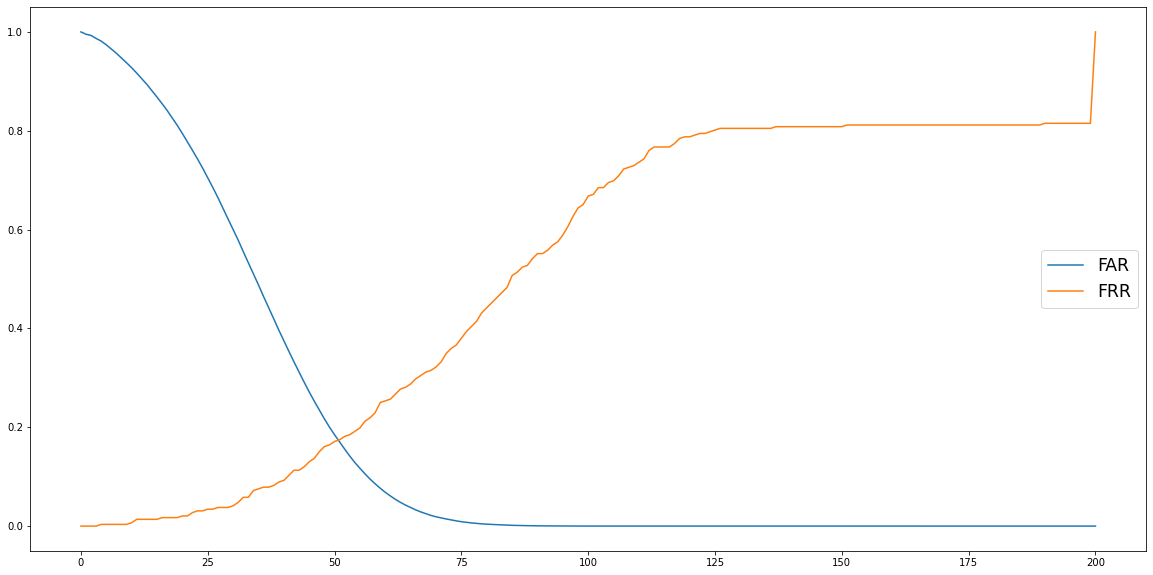

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(FAR, label = 'FAR')
plt.plot(FRR, label = 'FRR')
plt.legend(fontsize = 'xx-large')

# plt.annotate('EER = 0.291', xy=(16.5, 0.3),  xycoords='data',
#             xytext=(16.5, 0.6), textcoords='data',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='center', verticalalignment='top',
#             fontsize=20
#             )
plt.show()

## **Đối sánh 2 mẫu vân tay trong bộ dữ liệu:**

101 102


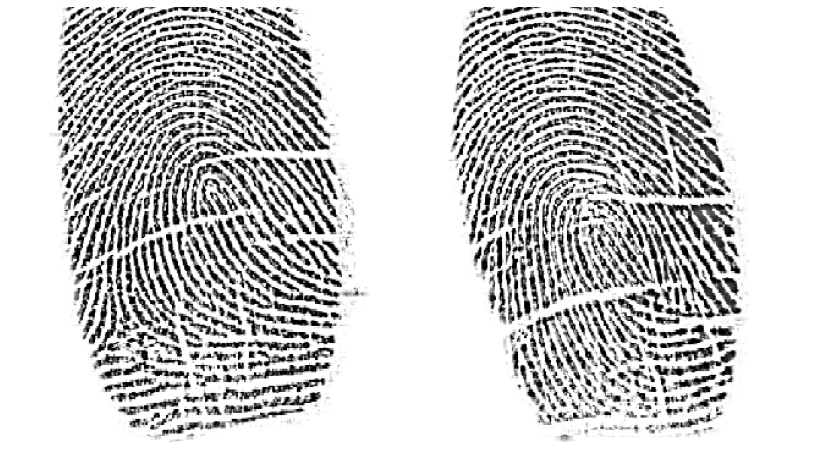

13.778016787395378

In [ ]:
file1 = filenames[8]
file2 = filenames[17]

img1 = cv2.imread(file1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(file2, cv2.IMREAD_GRAYSCALE)
print(file1[:-6], file2[:-6])
imshow(np.concatenate((img1,img2), axis=1))

features1 = feature_extractor(img1,3)
features2 = feature_extractor(img2,3)

matching_score(features1,features2, 3)